In [8]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix, hstack

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from xgboost.sklearn import XGBClassifier
import xgboost as xgb


%matplotlib inline


### Goal of work sheet
- V1:Optimize xgboost for training on brand / device
    - Alpha: increases for alpha value 1 to 5 and from 0.1 to 0.9, 0 is best value
    - Lambda: decreases for [-0.05, 0,  0.05, 0.1, 0.2, 0.5, 1, 2, 5], it decreases after five: [6, 7, 8, 10, 12, 15, 20]. 6.2 optimal 2.39044903984
    - Number rounds: 25, 50, 75, 100: increases with number of rounds, 175 seems optimal
- Select best data for model (onehotencoded both, separate, or just one)
    - Brands onehot, device label: 2.4304884100135387
    - Seperate onehot encoded: 2.3946668507651609 (requires regularization)
    - Combined onehot encoded: 2.402189399699036
- V2: Used couple of creative features based on brand and device model, also included brand when encoded device
    - Without scaler:
    - With scaler:

### Loading and preparing data

In [14]:
data_dir = './data_ori/'
feat_dir = './data/'
use_scaler = True

In [18]:
def open_feature_file(fname, samples='train'):
    if fname[-3:] == 'csv':
        if samples=='train':
            X = gatrain[['device_id']].merge( pd.read_csv(os.path.join(feat_dir, fname)), on='device_id', how='left')
        else:
            X = gatest[['device_id']].merge( pd.read_csv(os.path.join(feat_dir, fname)), on='device_id', how='left')
            
        X.drop('device_id', axis=1, inplace=True)
        X.fillna(0, inplace=True)
        
        if use_scaler:
            for c in X.columns:
                if X[c].max()>1:
                    X[c] = StandardScaler().fit_transform(X)
            
        #print X.shape
        return csr_matrix(X.values)
    else:
        # Assume it is a pickle file
        with open(os.path.join(feat_dir, '{}_{}.pickle'.format(fname,samples)), 'rb') as f:
            return pickle.load(f)
            
feature_files = ['features_brand_bag',
                 'features_brand_model_bag',
                 'features_brand_model.csv']

In [19]:
gatrain = pd.read_csv('./data_ori/gender_age_train.csv')
gatest = pd.read_csv('./data_ori/gender_age_test.csv')

In [20]:
Xtrain = hstack([open_feature_file(f) for f in feature_files], format='csr')
Xtest = hstack([open_feature_file(f,'test') for f in feature_files], format='csr')
y = gatrain['group']

In [21]:
letarget = LabelEncoder().fit(gatrain.group.values)
y = letarget.transform(gatrain.group.values)
n_classes = len(letarget.classes_)

In [22]:
print Xtrain.shape

(74645, 1803)


In [23]:
print 'X', Xtrain.shape
print 'y', y.shape

X (74645, 1803)
y (74645,)


## Using XGBoost

In [ ]:
for a in [0.05, 0.1, 0.2]:
    params = {
        "objective": "multi:softprob",
        'booster': 'gblinear',
        'num_class': 12,
        "eta": a,
        "silent": 1,
        'alpha':0,
        'lambda': 6.2,
        'n_estimators': int(25 * 0.1 / a),
        'eval_metric': 'mlogloss'
    }
    kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=0)
    pred = np.zeros((Xtrain.shape[0],n_classes))
    for itrain, itest in kf:
        ytrain, ytest = y[itrain], y[itest]
        xg_train = xgb.DMatrix( Xtrain[itrain, :], label=ytrain)
        xg_test = xgb.DMatrix(Xtrain[itest, :], label=ytest)
        watchlist = [ (xg_train,'train'), (xg_test, 'test') ]
        bst = xgb.train(params, xg_train, params['n_estimators'], watchlist, verbose_eval=50 )
        pred[itest,:] = bst.predict(xg_test)
    print a,':',log_loss(y, pred)

[0]	train-mlogloss:2.468150	test-mlogloss:2.470314
[49]	train-mlogloss:2.352679	test-mlogloss:2.393753
[0]	train-mlogloss:2.468231	test-mlogloss:2.470186
[49]	train-mlogloss:2.353117	test-mlogloss:2.391040
[0]	train-mlogloss:2.468302	test-mlogloss:2.469652
[49]	train-mlogloss:2.353637	test-mlogloss:2.385002
[0]	train-mlogloss:2.468381	test-mlogloss:2.469681
[49]	train-mlogloss:2.353578	test-mlogloss:2.387285
[0]	train-mlogloss:2.468147	test-mlogloss:2.470304
[49]	train-mlogloss:2.352578	test-mlogloss:2.394343
[0]	train-mlogloss:2.468280	test-mlogloss:2.469944
[49]	train-mlogloss:2.353273	test-mlogloss:2.388738
[0]	train-mlogloss:2.468163	test-mlogloss:2.470393
[49]	train-mlogloss:2.352496	test-mlogloss:2.394909
[0]	train-mlogloss:2.468160	test-mlogloss:2.470239
[49]	train-mlogloss:2.353076	test-mlogloss:2.390631
[0]	train-mlogloss:2.468295	test-mlogloss:2.469862
[49]	train-mlogloss:2.353308	test-mlogloss:2.389297
[0]	train-mlogloss:2.468322	test-mlogloss:2.469792
[49]	train-mlogloss:2.

0.05 : 2.39020375923


[0]	train-mlogloss:2.454458	test-mlogloss:2.458591
[24]	train-mlogloss:2.352374	test-mlogloss:2.393720
[0]	train-mlogloss:2.454494	test-mlogloss:2.458385
[24]	train-mlogloss:2.352876	test-mlogloss:2.391022
[0]	train-mlogloss:2.454751	test-mlogloss:2.457354


In [76]:
log_loss(y, pred)

2.3904596301097936

In [90]:
params = {
        "objective": "multi:softprob",
        'booster': 'gblinear',
        'num_class': 12,
        "eta": 0.01,
        "silent": 1,
        'alpha':0,
        'lambda': 6.2,
        'n_estimators': 25,
        'eval_metric': 'mlogloss'
    }

kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=0)
pred = np.zeros((X.shape[0],n_classes))
dtrain = xgb.DMatrix(X, label=y)
a=xgb.cv(params, dtrain, 400, nfold=5,
       metrics={'mlogloss'}, seed = 123)

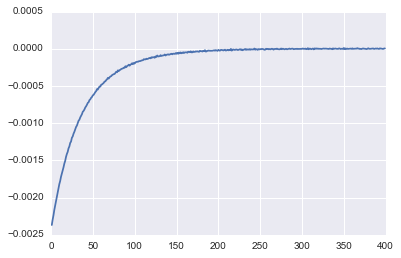

In [97]:
plt.plot(a['test-mlogloss-mean'].diff())